In [1]:
import torch, torchvision
import os
import random
import dataset
import metrics
import time
import utils

import constants as cst
import numpy as np
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
import loss_fn_v2 as loss_fn
import torchvision.transforms.functional as FF

from unet import UNET
from torchvision.ops import masks_to_boxes
from torchvision.utils import draw_segmentation_masks
from torchvision.utils import draw_bounding_boxes
from PIL import Image

In [2]:
def show_images(img):
    img = img
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
def validate(model, validation_loader, criterion):
    model.eval()
    with torch.no_grad():
        val_loss = []
        for images, masks, _, _ in validation_loader:
            outputs = model(images.to(DEVICE))

            masks = masks.type(torch.LongTensor)
            masks = torch.squeeze(masks, 1)

            vloss = criterion(outputs, masks.to(DEVICE))
            loss = vloss.detach().item()
            val_loss.append(loss)

        loss = np.mean(val_loss)
        # print("Validation loss before training: {}".format(loss))
    return loss

def train(model, training_loader, criterion, optimiser):
    model.train()
    train_loss = []
    for images, masks, _, _ in training_loader:
        outputs = model(images.to(DEVICE))

        masks = masks.type(torch.LongTensor)
        masks = torch.squeeze(masks, 1)

        tloss = criterion(outputs, masks.to(DEVICE))
        loss = tloss.detach().item()
        train_loss.append(loss)

        optimiser.zero_grad()
        tloss.backward()
        optimiser.step()

    loss = np.mean(train_loss)
    return loss

def evaluate(eval_model, testing_loader):
    tps = 0
    precisions = []
    recalls = []
    F1s = []
    IOUs = []
    
    eval_model.eval()
    for image, mask, name, size in testing_loader:
        h_length = int(size[0])
        v_length = int(size[1])
        if h_length>v_length:
            untr = transforms.Compose([transforms.Resize((h_length, h_length)),
                                       transforms.CenterCrop((v_length, h_length))])
        elif h_length<v_length:
            untr = transforms.Compose([transforms.Resize((v_length, v_length)),
                                       transforms.CenterCrop((v_length, h_length))])
        else:
            untr = transforms.Compose([transforms.Resize((h_length, h_length))])

        image_name = name[0]
        
        prediction = utils.predict_img(eval_model, image, DEVICE, untr, out_threshold=cst.THRESHOLD)
        pred = torch.from_numpy(prediction)
        """pr = pred * 1
        pr = pr.unsqueeze(dim=0)
        show_images(pr)"""

        mask = untr(mask)

        precisions.append(metrics.precision(pred, mask))
        recalls.append(metrics.recall(pred, mask))
        F1s.append(metrics.F1Score(pred, mask))
        IOUs.append(metrics.IOUScore(pred, mask))
    return precisions, recalls, F1s, IOUs

In [3]:
random.seed(cst.SEED)
torch.manual_seed(cst.SEED)
np.random.seed(cst.SEED)

DEVICE_NAME = "cpu"
if torch.cuda.is_available():
    DEVICE_NAME = 'cuda:0'
DEVICE = torch.device(DEVICE_NAME)

# Model used to first crop the fish out of the image
model_name = "fish_CE_Fold_4_Epoch_95_MaxEpochs_600_Adam_LR_0.0001.pth"
model_path = os.path.join(cst.MODEL, model_name)

fish_model = utils.load_model(model_path)
fish_model.to(DEVICE)

TERMS = ["p"]
SIZE = (384, 512)
FOLDS = [4]    # 0 to 4 only a few folds at a time here for computational resources limit

Starting term: p
Starting fold: 4
Training set length: 84
Validation set length: 20
Testing set length: 20
Loss used: Tversky
Epoch: 50
Validation: 0.028231489658355712.
Best: 0.028231489658355712.
Epoch: 100
Validation: 0.0110921710729599.
Best: 0.0110921710729599.
Epoch: 150
Validation: 0.007266291975975036.
Best: 0.007266291975975036.
Epoch: 200
Validation: 0.006193614006042481.
Best: 0.0061792820692062374.
Epoch: 250
Validation: 0.005617296695709229.
Best: 0.005565047264099121.
Epoch: 300
Validation: 0.005323374271392822.
Best: 0.0052580684423446655.
Epoch: 350
Validation: 0.005260872840881348.
Best: 0.005170685052871704.
Epoch: 400
Validation: 0.005530166625976563.
Best: 0.0050184279680252075.


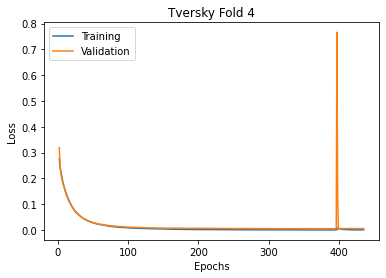

Last epoch: 434
Term: p
Fold: 4
Fold took: 318.0 minutes 38.2128746509552 seconds to train
Last val: 0.005345931649208069
Best val: 0.0050184279680252075

Precision: 0.9803494688810176
90% CI: [0.91980027 1.        ]
Min, max: 0.8439823649398933 0.9999999999996522

Recall: 0.7055495690905732
90% CI: [0.61456104 0.80563907]
Min, max: 0.44705962614261907 0.8264707777557662

F1/Dice score: 0.8168249900671825
90% CI: [0.75768887 0.85853171]
Min, max: 0.6178481072331163 0.8882170116495998

IoU: 0.6934927664059247
90% CI: [0.61087342 0.75219322]
Min, max: 0.4470189640273667 0.7989122166435422

--------------------

ALL FOLDS TRAINING ENDED
Mean best validation: 0.0050184279680252075
Mean precision: 0.9803494688810176
Mean recall: 0.7055495690905732
Mean F1: 0.8168249900671825
Mean IOU: 0.6934927664059247



In [4]:
for TERM in TERMS:
    print("Starting term: " + TERM)
    start_term = time.time()
    
    image_folder = "/notebooks/images"
    mask_folder = "/notebooks/" + TERM
    
    transform = transforms.Compose([transforms.Resize(SIZE),
                                    transforms.Pad((0, 64, 0, 64))])
    untransform = transforms.Compose([transforms.CenterCrop(SIZE),
                                     transforms.Resize((1932, 2576))])
    
    fold_validation = []
    fold_precision = []
    fold_recall = []
    fold_f1 = []
    fold_IOU = []
    
    for fold in FOLDS:
        print("Starting fold: {}".format(fold))
        start_fold = time.time()
        """Datasets and loaders"""
        training_set = dataset.ZebrafishDataset_KFold_crop_head(image_folder,
                                                           mask_folder,
                                                           actual_fold=fold,
                                                           model = fish_model,
                                                           device = DEVICE,
                                                           dataset="train",
                                                           folds = cst.FOLDS)

        validation_set = dataset.ZebrafishDataset_KFold_crop_head(image_folder,
                                                           mask_folder,
                                                           actual_fold=fold,
                                                           model = fish_model,
                                                           device = DEVICE,
                                                           dataset="validate",
                                                           folds = cst.FOLDS)
        
        testing_set = dataset.ZebrafishDataset_KFold_crop_head(image_folder,
                                                           mask_folder,
                                                           actual_fold=fold,
                                                           model = fish_model,
                                                           device = DEVICE,
                                                           dataset="test",
                                                           folds = cst.FOLDS)

        training_loader = torch.utils.data.DataLoader(training_set,
                                                      batch_size=cst.BATCH_SIZE,
                                                      shuffle=True,
                                                      num_workers=cst.WORKERS)

        validation_loader = torch.utils.data.DataLoader(validation_set,
                                                        batch_size=cst.BATCH_SIZE,
                                                        shuffle=True,
                                                        num_workers=cst.WORKERS)

        testing_loader = torch.utils.data.DataLoader(testing_set,
                                                     batch_size=1,
                                                     shuffle=True,
                                                     num_workers=cst.WORKERS)
        
        
        model = UNET(3, 2)
        model.to(DEVICE)
        best_model = UNET(3, 2)
        best_model = model
        
        criterion = nn.CrossEntropyLoss()
        criterion_string = "CE"

        if cst.LOSS == "Dice":
            print("Loss used: Dice")
            criterion = loss_fn.DiceLoss()
            criterion_string = "DCE"
        if cst.LOSS == "IOU":
            print("Loss used: IOU")
            criterion = loss_fn.IoULoss()
            criterion_string = "IOU"
        if cst.LOSS == "Tversky":
            print("Loss used: Tversky")
            criterion = loss_fn.TverskyLoss(alpha=0.7, beta= 0.3)
            criterion_string = "Tversky"
        if cst.LOSS == "Focal":
            print("Loss used: Focal")
            criterion = loss_fn.FocalLoss(alpha=0.8, gamma= 2, reduction="mean")
            criterion_string = "Focal"

        optimiser = torch.optim.Adam(model.parameters(), lr=cst.LEARNING_RATE, weight_decay=cst.WEIGHT_DECAY)
        optimiser_string = "ADAM" + "_" + "LR" + str(cst.LEARNING_RATE) + "_" + "WD" + str(cst.WEIGHT_DECAY)
        
        if cst.OPTIMIZER == "SGD":
            optimizer = torch.optim.SGD(model.parameters(),
                                        lr=cst.LEARNING_RATE,
                                        momentum=cst.MOMENTUM,
                                        weight_decay=cst.WEIGHT_DECAY)
            optimiser_string = "SGD" + "_" + "LR" + str(cst.LEARNING_RATE) + "_" + "M" + str(cst.MOMENTUM)
            optimiser_string += "_" + "WD" + str(cst.WEIGHT_DECAY)
        
        params_string = "Params" + "_" + "Epoch" + str(cst.EPOCHS) + "_" + "BS" + str(cst.BATCH_SIZE)
        params_string += "_" + "W" + str(cst.WORKERS)
        
        """Computing validation loss before training"""
        loss = validate(model, validation_loader, criterion)
            
        best_val = loss
        best_epoch = 0
        last_epoch = 0
        
        epochs_train_losses = []
        epochs_val_losses = []
        for epoch in range(cst.EPOCHS):
            """ Training """
            loss = train(model, training_loader, criterion, optimiser)
            epochs_train_losses.append(loss)

            """ Validation """
            loss = validate(model, validation_loader, criterion)
            epochs_val_losses.append(loss)
            
            # Updating best model
            if loss < best_val:
                best_val = loss
                best_model = model
                best_epoch = epoch+1
            
            if (epoch+1)%50 == 0:
                print("Epoch: " + str(epoch+1))
                print("Validation: {}.".format(loss))
                print("Best: {}.".format(best_val))
                    
            """Train and validate loops over"""
            curr = time.time()
            curr = curr - start_term
            secondes = curr % 60
            minutes = (curr-secondes)/60
            
            last_epoch = epoch
            
            # Notebooks shutdown after 6 hours. Stop the code and save the results.
            if minutes >= 345:
                break
            if (epoch - best_epoch) >= 50:
                break
            
        """All epochs are over""" 
        fold_validation.append(best_val)
        
        model_name = TERM + '_head_crop_k5_' + cst.LOSS + "_Fold_" + str(fold) + "_Epoch_" + str(best_epoch) + "_MaxEpochs_" 
        model_name += str(cst.EPOCHS) + '_' + cst.OPTIMIZER + "_LR_" + str(cst.LEARNING_RATE) + ".pth"
        
        model_filepath = os.path.join(cst.MODEL, model_name)
        torch.save(best_model.state_dict(), model_filepath)
        
        index = [i+1 for i in range(last_epoch+1)]
        plt.plot(index[1:], epochs_train_losses[1:], label="Training")
        plt.plot(index[1:], epochs_val_losses[1:], label="Validation")
        plt.title(str(cst.LOSS) + " Fold " + str(fold)) 
        plt.ylabel("Loss")
        plt.xlabel("Epochs")
        plt.legend()
        plt.show()
        
        """Evaluating"""
        precisions, recalls, F1s, IOUs = evaluate(best_model, testing_loader)
        
        mean_precision = np.mean(precisions)
        mean_recall = np.mean(recalls)
        mean_f1 = np.mean(F1s)
        mean_IOU = np.mean(IOUs)
        
        fold_precision.append(mean_precision)
        fold_recall.append(mean_recall)
        fold_f1.append(mean_f1)
        fold_IOU.append(mean_IOU)
        
        confidence = 0.9
        
        curr = time.time()
        curr = curr - start_fold
        secondes = curr % 60
        minutes = (curr-secondes)/60
        
        #print("--------------------")
        print("Last epoch: {}".format(last_epoch))
        print("Term: " + TERM)
        print("Fold: {}".format(fold))
        print("Fold took: " + str(minutes) + " minutes " + str(secondes) + " seconds to train")
        print("Last val: {}".format(loss))
        print("Best val: {}".format(best_val))
        print()
        print("Precision: {}".format(mean_precision))
        print("90% CI: {}".format(np.percentile(precisions, [100*(1-confidence)/2,100*(1-(1-confidence)/2)])))
        print("Min, max:", np.min(precisions), np.max(precisions))
        print()

        print("Recall: {}".format(mean_recall))
        print("90% CI: {}".format(np.percentile(recalls, [100*(1-confidence)/2,100*(1-(1-confidence)/2)])))
        print("Min, max:", np.min(recalls), np.max(recalls))
        print()

        print("F1/Dice score: {}".format(mean_f1))
        print("90% CI: {}".format(np.percentile(F1s, [100*(1-confidence)/2,100*(1-(1-confidence)/2)])))
        print("Min, max:", np.min(F1s), np.max(F1s))
        print()

        print("IoU: {}".format(mean_IOU))
        print("90% CI: {}".format(np.percentile(IOUs, [100*(1-confidence)/2,100*(1-(1-confidence)/2)])))
        print("Min, max:", np.min(IOUs), np.max(IOUs))
        print()
        print("--------------------")
        
    """Fold loop end"""
    print()
    print("ALL FOLDS TRAINING ENDED")
    print("Mean best validation: {}".format(np.mean(fold_validation)))
    print("Mean precision: {}".format(np.mean(fold_precision)))
    print("Mean recall: {}".format(np.mean(fold_recall)))
    print("Mean F1: {}".format(np.mean(fold_f1)))
    print("Mean IOU: {}".format(np.mean(fold_IOU)))
"""term loop end"""
print()    
    